<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/P5_Ch05_CH11_06_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE_Fashion_MNIST_TF

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/#fastcampus
!pwd

!ls

/content/drive/MyDrive/#fastcampus
/content/drive/MyDrive/#fastcampus
 config_utils.py      data_utils.py	 runs
 config_utils_tf.py   __init__.py	 wandb
 config.yaml	      logs		'[강의자료]-노트북-ipynb-파일'
 custom_math.py       __pycache__
 data		      requirements.txt


In [ ]:
import os
import sys
sys.path.append('/content/drive/MyDrive/#fastcampus')
drive_project_root = '/content/drive/MyDrive/#fastcampus'
!pip install -r '/content/drive/MyDrive/#fastcampus/requirements.txt'

In [ ]:
!pip install tensorflow-addons
!pip install wandb
!pip install omegaconf
!pip install hydra-core==1.1


In [5]:
from datetime import datetime
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from omegaconf import DictConfig
import hydra
from hydra.core.config_store import ConfigStore

import tensorflow as tf
import tensorflow_addons as tfa

import wandb


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
from data_utils import dataset_split
from config_utils_tf import flatten_dict
from config_utils_tf import register_config
from config_utils_tf import get_optimizer_element
from config_utils_tf import get_callbacks

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
!nvidia-smi

Mon Aug 14 07:17:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 데이터 및 데이터로더 정의

## 모델정의


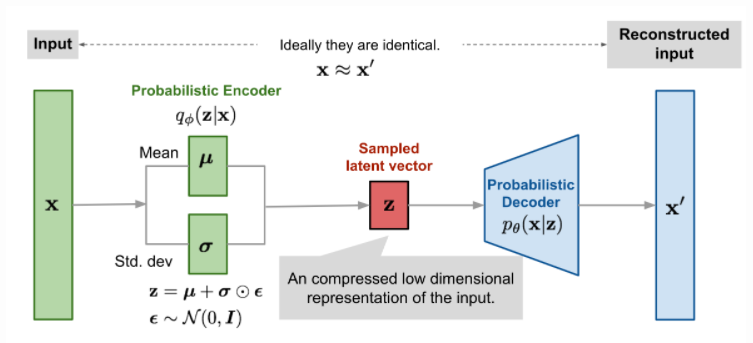

In [10]:
class VAE(tf.keras.Model):
  """Convolutional variational autoencoder"""
  def __init__(self, cfg : DictConfig):
    super().__init__() # 클래스를 상속받았기 때문에 init해줘야한다
    self.cfg = cfg
    self.latent_dim = cfg.model.latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(**cfg.model.enc.conv1),
            tf.keras.layers.Conv2D(**cfg.model.enc.conv1),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(cfg.model.enc.out_fc.units),
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                units = cfg.model.dec.in_fc.units,
                activation = tf.nn.relu
            ),
            tf.keras.layers.Reshape(
                target_shape = tuple(cfg.model.dec.reshape_shape)
            ),
            tf.keras.layers.Conv2DTranspose(),
            tf.keras.layers.Conv2D(**cfg.model.dec.tr_conv1),
            tf.keras.layers.Conv2D(**cfg.model.dec.tr_conv2),
            tf.keras.layers.Conv2D(**cfg.model.dec.tr_conv3),

        ]
    )
    self.total_loss_tracker = tf.keras.metrics.Mean(name ="total_loss")
    self.recon_loss_tracker = tf.keras.metrics.Mean(name ="recon_loss")
    self.kl_loss_tracker = tf.keras.metrics.Mean(name ="kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.recon_loss_tracker,
        self.kl_loss_tracker
    ]

  @tf.function
  def sample(self, epsilon = None, sample_size = 100 ):
    if epsilon is None :
      eps = tf.random.normal(shape = (sample_size, self.latent_dim))
      return self.decode(eps)

  def encode(self, x, training= False):
    mu, logvar = tf.split(
        self.encoder(x, training = training),
        num_or_size_splits=2,
        axis =1)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    """get z"""
    epsilon = tf.random.normal(shape =(sample_size, self.latent_dim))
    return mu + epsilon * tf.exp(logvar * .5)

  def decode(self, z, training = False):
    return tf.sigmoid(self.decoder(z, training =training))

  def call(self, input, training = False):
    mu, logvar = self.encode(input, training = training)
    z = self.reparameterize(mu, logvar)
    output = self.decode(self, training = training)
    return output , z, mu, logvar

  def train_step(self, data):
    images, _ = data
    #images =[B, 28, 28] -> [B, 28, 28, 1]
    images = tf.expand_dims(images, -1).astype(tf.float32)

    with tf.GradientTape() as tape :
      outputs, z, z_mu, z_logvar = self(images, training = True)

      # reconstruction loss
      recon_loss = tf.reduce_mean(
          tf.reduce_sum( # batch 별로
            tf.keras.losses.mae(images, outputs), # image 별로
            axis = (1,2)
          )
      )
      # kld_loss
      kl_loss = -0.5 * (1 + z_logvar - tf.square(z_mu) - tf.exp(z_logvar))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))

      # total_loss
      total_loss = recon_loss + kl_loss

      # compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(total_loss, trainable_vars)

      # update the metrics
      self.total_loss_tracker.update_state(total_loss)
      self.recon_loss_tracker.update_state(recon_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      # tensorboard image update
      tf.summary.image("train_source_img", images, max_outputs =5)
      tf.summary.image("train_recon_img", outputs, max_outputs =5)

      # return a dict mapping metrics names to current values
      logs = {m.name : m.result() for m in self.metrics}
      return logs

  def test_step(self, data):
    images, _ = data
    #images =[B, 28, 28] -> [B, 28, 28, 1]
    images = tf.expand_dims(images, -1).astype(tf.float32)

    outputs, z, z_mu, z_logvar = self(images, training = True)

    # reconstruction loss
    recon_loss = tf.reduce_mean(
          tf.reduce_sum( # batch 별로
            tf.keras.losses.mae(images, outputs), # image 별로
            axis = (1,2)
          )
    )
    # kld_loss
    kl_loss = -0.5 * (1 + z_logvar - tf.square(z_mu) - tf.exp(z_logvar))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))

    # total_loss
    total_loss = recon_loss + kl_loss

    # update the metrics
    self.total_loss_tracker.update_state(total_loss)
    self.recon_loss_tracker.update_state(recon_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    # tensorboard image update
    tf.summary.image("train_source_img", images, max_outputs =5)
    tf.summary.image("train_recon_img", outputs, max_outputs =5)

    # return a dict mapping metrics names to current values
    logs = {m.name : m.result() for m in self.metrics}
    return logs



## configuration 정의

In [9]:
# data configuration
data_fashion_mnist_cfg : dict ={
    "n_class_": 10,
    "train_val_split" : [0.9,0.1],
    "train_val_shuffle" : True,
    "train_val_shuffle_buffer_size" : 1024,
    "test_shuffle" : False,
    "test_shuffle_buffer_size" : 1024,

}

# model configuration

model_mnist_vae_cfg : dict ={
    'name' : 'VAE',
    'data_normalize': True,
}


# optimizer_configs

adam_warmup_lr_sch_opt_cfg  ={
    "optimizer" :{
        "name" : "Adam",
        "other_kwargs" :{}, # 빈값이면 기본이 들어감
    },
    "lr_scheduler":{
        "name" : "LinearWarmupLRSchedule",
        "kwargs" : {
            "lr_peak" : 1e-3,
            "warmup_end_steps" : 1500,
        }
    }
}

radam_no_lr_sch_opt_cfg  ={ # Radam은 굳이 스케줄러 필요 없음
    "optimizer" :{
        "name" : "RectifiedAdam",
        "learning_rate" : 1e-3,
        "other_kwargs" :{}, # 빈값이면 기본이 들어감
    },
    "lr_scheduler": None
}

# train configs

train_cfg : dict ={
    "train_batch_size" : 128,
    "val_batch_size" : 32,
    "test_batch_size" : 32,
    "max_epochs" : 50,
    "distribute_strategy" : "MirroredStrategy",
}

_merged_cfg_presets ={
    "vae_fashion_mnist_radam" :{
        "data" : data_fashion_mnist_cfg,
        "model" : model_mnist_vae_cfg,
        "opt" : radam_no_lr_sch_opt_cfg,
        "train" : train_cfg,

    },
}

### hydra composition ###
# clear hydra instance.
hydra.core.global_hydra.GlobalHydra.instance().clear()

# resister preset cfgs
register_config(_merged_cfg_presets)

# initializing
hydra.initialize(config_path =None)

using_config_key = "vae_fashion_mnist_radam"
cfg = hydra.compose(using_config_key)

# define & override log_cfg
model_name = cfg.model.name
run_dirname ='fastcampus_generative_model_tutorials_tf'
run_name = f'{datetime.now().isoformat(timespec="seconds")} -{using_config_key}-{model_name}'
log_dir = os.path.join(drive_project_root, 'runs', run_dirname, run_name)




log_cfg ={
    "run_name" : run_name,
    "callbacks" : {
        "TensorBoard" :{
          "log_dir" :log_dir,
          "update_freq" :1,
        },
        "EarlyStopping" : {
          "patience" : 3,
          "verbose" : True,
        },
    },
    "wandb" : {
        "project" : "fastcampus_generative_model_tutorials_tf",
        "name" : run_name,
        "tags" : ["fastcampus_generative_model_tutorials_tf"],
        "reinit" : True,
        "sync_tensorboard" : True
        }

}

# unlock struct of config & set log config
OmegaConf.set_struct(cfg, False)
cfg.log =log_cfg

# relock config
OmegaConf.set_struct(cfg, True)
print(OmegaConf.to_yaml(cfg))

# save yaml
# with open(os.path.join(log_dir, "config.yaml")) as f :
with  open("config.yaml", "w") as f :
  OmegaConf.save(cfg, f)

data:
  n_class_: 10
  train_val_split:
  - 0.9
  - 0.1
  train_val_shuffle: true
  train_val_shuffle_buffer_size: 1024
  test_shuffle: false
  test_shuffle_buffer_size: 1024
model:
  name: VAE
  data_normalize: true
opt:
  optimizer:
    name: RectifiedAdam
    learning_rate: 0.001
    other_kwargs: {}
  lr_scheduler: null
train:
  train_batch_size: 128
  val_batch_size: 32
  test_batch_size: 32
  max_epochs: 50
  distribute_strategy: MirroredStrategy
log:
  run_name: 2023-08-14T07:27:38 -vae_fashion_mnist_radam-VAE
  callbacks:
    TensorBoard:
      log_dir: /content/drive/MyDrive/#fastcampus/runs/fastcampus_generative_model_tutorials_tf/2023-08-14T07:27:38
        -vae_fashion_mnist_radam-VAE
      update_freq: 1
    EarlyStopping:
      patience: 3
      verbose: true
  wandb:
    project: fastcampus_generative_model_tutorials_tf
    name: 2023-08-14T07:27:38 -vae_fashion_mnist_radam-VAE
    tags:
    - fastcampus_generative_model_tutorials_tf
    reinit: true
    sync_tensorboard

In [ ]:
def get_distribute_strategy(strategy_name : str, **kwargs):
  return getattr(tf.distribute, strategy_name)(**kwargs)

distribute_strategy = get_distribute_strategy(cfg.train.distribute_strategy)

In [ ]:
with distribute_strategy.scope():
  # 데이터셋 정의
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

  # normalization
  if cfg.model.data_normalize:
      x_train =x_train/255.0
      x_test = x_test/255.0

  # train/val splits
  assert sum(cfg.data.train_val_split) ==1.0
  train_size = int(len(x_train)*cfg.data.train_val_split[0])
  val_size = len(x_train) -train_size

  dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

  test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
  if cfg.data.train_val_shuffle :
    dataset = dataset.shuffle(
        buffer_size = cfg.data.train_val_shuffle_buffer_size,
        )
  if cfg.data.test_shuffle :
    test_dataset = test_dataset.shuffle(
        buffer_size= cfg.data.test_shuffle_buffer_size,
    )


  train_dataset = dataset.take(train_size)
  val_dataset = dataset.skip(train_size)
  print(len(train_dataset), len(val_dataset), len(dataset), len(test_dataset))

  # dataloader 정의
  train_batch_size = cfg.train.train_batch_size
  val_batch_size = cfg.train.val_batch_size
  test_batch_size = cfg.train.test_batch_size

  train_dataloader = train_dataset.batch(train_batch_size, drop_remainder=True)
  val_dataloader = val_dataset.batch(val_batch_size, drop_remainder=True)
  test_dataloader = test_dataset.batch(test_batch_size, drop_remainder=True)

sample_example = next(iter(train_dataloader))
print(sample_example)

4422102/4422102 [==============================] - 1s 0us/step
54000 6000 60000 10000
(<tf.Tensor: shape=(128, 28, 28), dtype=float64, numpy=
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00392157, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.00392157, 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.62745098, 0.85098039, ..., 0.8       ,
         0.48627451, 0.        ],
        [0.        , 0.62352941, 0.96078431, ..., 0.87058824,
         0.58431373, 0.        ],
        [0.        , 0.14509804, 0.49019608, ..., 0.36470588,
         0.07843137, 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.  

In [ ]:
# 모델정의
def get_model(cfg : DictConfig):
  if cfg.model.name =="VAE":
    model = VAE(cfg.model)

  else:
    raise NotImplementedError()
  return model



with distribute_strategy.scope():
     model = get_model(cfg)

    #define loss
     loss_function = tf.losses.SparseCategoricalCrossentropy() # from_logits = False면 prob으로 리턴, True면 softmax없이 logit값 써도 된다.

    #define optimizer & scheduler
     optimizer, scheduler = get_optimizer_element(
        cfg.opt.optimizer, cfg.opt.lr_scheduler
        )

     model.compile(
        loss = loss_function,
        optimizer = optimizer,
        metrics = [tf.keras.metrics.Accuracy()],
     )

     model.build((1, 28,28)) #디버깅할떄 좋음

model.summary()
# model.fit(train_dataloader, test_dataloader, call)

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_batch_norm_max_pool (C  multiple                 448       
 onvBatchNormMaxPool)                                            
                                                                 
 conv_batch_norm_max_pool_1   multiple                 18752     
 (ConvBatchNormMaxPool)                                          
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  3965440   
                                                                 
 dense_1 (Dense)             multiple                  65664     
                                                                 
 dense_2 (Dense)             multiple                  1290    

In [ ]:
flatten_dict(cfg)

{'data_n_class_': 10,
 'data_train_val_split': [0.9, 0.1],
 'data_train_val_shuffle': True,
 'data_train_val_shuffle_buffer_size': 1024,
 'data_test_shuffle': False,
 'data_test_shuffle_buffer_size': 1024,
 'model_name': 'CNN',
 'model_data_normalize': True,
 'model_layer_1_conv2d_filters': 32,
 'model_layer_1_conv2d_kernel_size': [3, 3],
 'model_layer_1_conv2d_strides': [1, 1],
 'model_layer_1_conv2d_padding': 'same',
 'model_layer_1_maxpool2d_pool_size': [2, 2],
 'model_layer_1_maxpool2d_strids': [2, 2],
 'model_layer_1_maxpool2d_padding': 'valid',
 'model_layer_2_conv2d_filters': 64,
 'model_layer_2_conv2d_kernel_size': [3, 3],
 'model_layer_2_conv2d_strides': [1, 1],
 'model_layer_2_conv2d_padding': 'valid',
 'model_layer_2_maxpool2d_pool_size': [2, 2],
 'model_layer_2_maxpool2d_strids': [1, 1],
 'model_layer_2_maxpool2d_padding': 'valid',
 'model_fc_1_units': 512,
 'model_fc_2_units': 128,
 'model_fc_3_units': 10,
 'model_dropout_prob': 0.25,
 'opt_optimizer_name': 'RectifiedAdam'

In [ ]:
# get callbacks
callbacks = get_callbacks(cfg.log)

# wandb setup
wandb.init(
    config = flatten_dict(cfg),
    **cfg.log.wandb
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/\#fastcampus/runs/
model.fit(
    train_dataloader,
    validation_data = val_dataloader,
    epochs = cfg.train.max_epochs,
    callbacks =callbacks,
)


Launching TensorBoard...

## Model testing

In [ ]:
model.evaluate(test_dataloader)

100/100 [==============================] - 1s 5ms/step - loss: 0.3435 - accuracy: 0.8992


[0.34348130226135254, 0.8992000222206116]

In [ ]:
test_labels_list =[]
test_preds_list =[]
test_outputs_list =[]

for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position =0, leave =True, desc='testing')):
  with mirrored_strategy.scope():
    test_outputs = model(test_images)
  test_preds = tf.argmax(test_outputs, 1)

  final_outs = test_outputs.numpy()
  test_outputs_list.extend(final_outs)
  test_preds_list.extend(test_preds.numpy())
  test_labels_list.extend(test_labels.numpy())

test_preds_list =np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

test_accuracy =np.mean(test_preds_list == test_labels_list)
print(f'\nacc: {test_accuracy*100}%')

testing: 100%|██████████| 100/100 [00:01<00:00, 54.22it/s]


acc: 89.92%


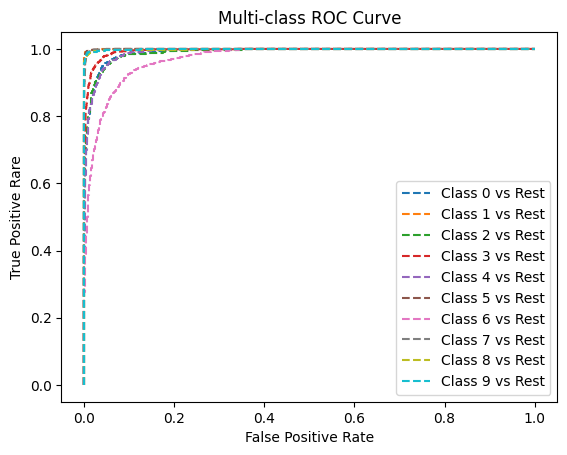

auc_score : 0.9931041944444445


In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr ={}
tpr ={}
thresh = {}
n_class =10

for i in range(n_class):
  fpr[i], tpr[i], thresh[i] =roc_curve(test_labels_list, np.array(test_outputs_list)[:,i], pos_label =i) #class별로 따로따로

#plot
for i in range(n_class):
  plt.plot(fpr[i], tpr[i], linestyle ='--', label=f'Class {i} vs Rest')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rare')
plt.legend(loc ='best')
plt.show()

auc_score = roc_auc_score(test_labels_list, test_outputs_list, multi_class ='ovo', average ='macro')
print(f'auc_score : {auc_score}')